In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
%%time
adata = sc.read('../data/processed/pbmc68k/pmbc_embeddings_nbrs_10_hvgs_1000_dim_2.h5ad')

Wall time: 166 ms


In [3]:
adata

AnnData object with n_obs × n_vars = 68515 × 1000
    obs: 'bulk_labels', 'n_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'bulk_labels_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pacmap', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
umap_coordinates = adata.obsm['X_umap']
pacmap_coordinates = adata.obsm['X_pacmap']

In [5]:
from sklearn import mixture
from sklearn.metrics import v_measure_score,adjusted_rand_score

### Tuning GMM Parameters using BIC

In [6]:
%%time

n_components = range(1, 12)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]

for cov in covariance_type:
    for n_comp in n_components:
        gmm=mixture.GaussianMixture(n_components=n_comp,covariance_type=cov,random_state=42,reg_covar=1e-05)
        gmm.fit(umap_coordinates)
        score.append({'covariance':cov,'components':n_comp,'bic_score':gmm.bic(umap_coordinates)})

sc.logging.print_memory_usage()

Memory usage: current 0.49 GB, difference +0.49 GB
Wall time: 15.9 s


In [7]:
df_bic = pd.DataFrame(score)
df_bic.sort_values(by='bic_score')

,covariance,components,bic_score
43,full,11,674228.555561
42,full,10,674835.990239
41,full,9,675356.885791
40,full,8,678203.909898
32,diag,11,678213.027065
31,diag,10,679493.615602
30,diag,9,679628.509965
10,spherical,11,681003.467972
29,diag,8,681604.091365
8,spherical,9,682125.721853


### GMM

In [8]:
%%time
model = mixture.GaussianMixture(n_components=11, covariance_type='full', verbose=1, verbose_interval=10, random_state=42,reg_covar=1e-05).fit(umap_coordinates)
sc.logging.print_memory_usage()

Initialization 0
  Iteration 10
Initialization converged: True
Memory usage: current 0.49 GB, difference +0.00 GB
Wall time: 1.15 s


In [9]:
%%time
model2 = mixture.GaussianMixture(n_components=11, covariance_type='full', verbose=1, verbose_interval=10, random_state=42,reg_covar=1e-05).fit(pacmap_coordinates)
sc.logging.print_memory_usage()

Initialization 0
Initialization converged: True
Memory usage: current 0.49 GB, difference +0.00 GB
Wall time: 959 ms


In [10]:
%%time
adata.obs['gmm_umap'] = model.predict(umap_coordinates)
adata.obs['gmm_umap'] = adata.obs['gmm_umap'].astype(str)

adata.obs['gmm_pacmap'] = model2.predict(pacmap_coordinates)
adata.obs['gmm_pacmap'] = adata.obs['gmm_pacmap'].astype(str)

Wall time: 161 ms


### Cluster Visualization

In [12]:
import matplotlib.pyplot as plt

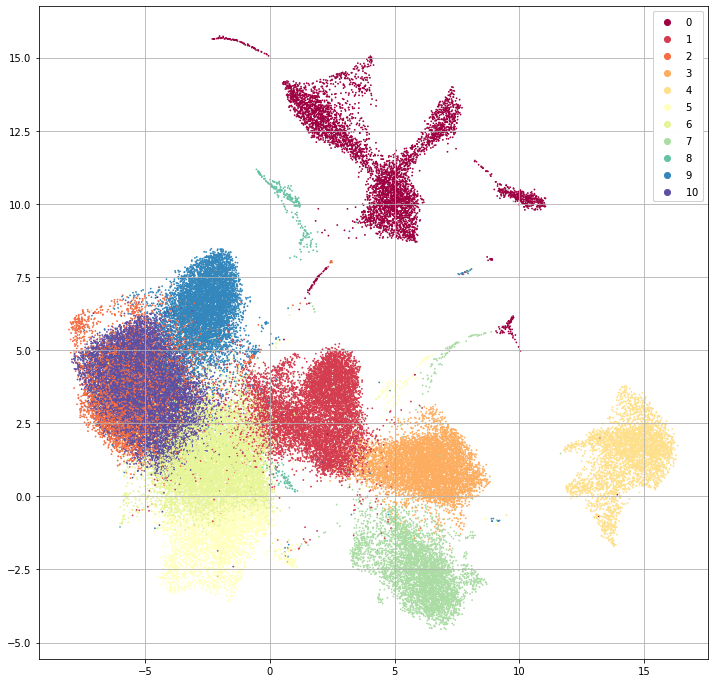

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.grid()
scatter = ax.scatter(umap_coordinates[:, 0], umap_coordinates[:, 1], cmap="Spectral", c=adata.obs['gmm_pacmap'].cat.codes.values,s=0.6)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best")
ax.add_artist(legend1)

plt.savefig('figures/gmm_pbmc_u.jpg',bbox_inches='tight',dpi=600)

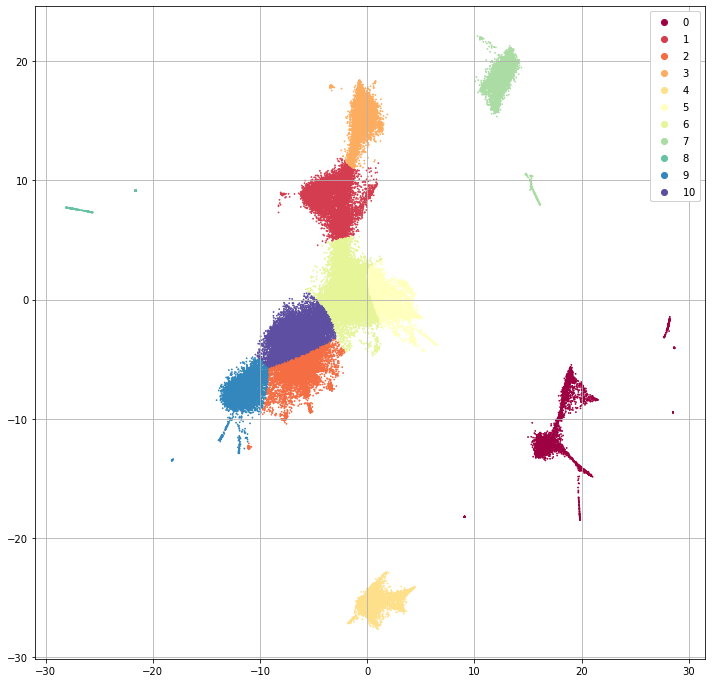

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.grid()
scatter = ax.scatter(pacmap_coordinates[:, 0], pacmap_coordinates[:, 1], cmap="Spectral", c=adata.obs['gmm_pacmap'].cat.codes.values,s=0.6)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best")
ax.add_artist(legend1)

plt.savefig('figures/gmm_pbmc.jpg',bbox_inches='tight',dpi=600)

In [15]:
adata

AnnData object with n_obs × n_vars = 68515 × 1000
    obs: 'bulk_labels', 'n_counts', 'gmm_umap', 'gmm_pacmap'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'bulk_labels_colors', 'hvg', 'log1p', 'neighbors', 'umap', 'gmm_umap_colors'
    obsm: 'X_pacmap', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

### Model Evaluation (ARI and V-measure)

In [16]:
%%time
rand_index = adjusted_rand_score(labels_true = adata.obs['bulk_labels'], labels_pred = adata.obs['gmm_umap'])
print('Rand index:', round(rand_index, 2))

Rand index: 0.24
Wall time: 115 ms


In [17]:
%%time
rand_index = adjusted_rand_score(labels_true = adata.obs['bulk_labels'], labels_pred = adata.obs['gmm_pacmap'])
print('Rand index:', round(rand_index, 2))

Rand index: 0.26
Wall time: 115 ms


In [23]:
%%time
v_measure_score(adata.obs['bulk_labels'], adata.obs['gmm_umap'])

Wall time: 168 ms


0.4552101167209465

In [24]:
%%time
v_measure_score(adata.obs['bulk_labels'], adata.obs['gmm_pacmap'])

Wall time: 168 ms


0.46739608649062797

### Post-cluster assignment sampling

In [25]:
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter

In [26]:
%%time
Counter(adata.obs['gmm_pacmap'])

Wall time: 5.98 ms


Counter({'1': 8685,
         '9': 7057,
         '6': 10074,
         '4': 3877,
         '10': 12370,
         '3': 6679,
         '2': 5438,
         '5': 4133,
         '0': 5171,
         '7': 4699,
         '8': 332})

In [27]:
%%time
enn = EditedNearestNeighbours(sampling_strategy='all',n_jobs=-1,n_neighbors=10, kind_sel='all')
X_res, y_res = enn.fit_resample(umap_coordinates, adata.obs['gmm_pacmap'])

Wall time: 475 ms


In [28]:
Counter(y_res)

Counter({'0': 5064,
         '1': 6196,
         '10': 535,
         '2': 253,
         '3': 5798,
         '4': 3824,
         '5': 2200,
         '6': 2712,
         '7': 4288,
         '8': 274,
         '9': 4621})

In [29]:
X_res.shape

(35765, 2)

In [30]:
umap_coordinates.shape

(68515, 2)

### Rare-cell sub-population identification

#### OCSVM

In [31]:
from sklearn.svm import OneClassSVM

In [32]:
%%time
ocsvm = OneClassSVM(gamma=0.002,verbose=True,max_iter=10,nu=0.9).fit(pacmap_coordinates)

[LibSVM]Wall time: 2min 38s


F:\Applications\Anaconda\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [33]:
%%time
pd.Series(ocsvm.predict(pacmap_coordinates)).value_counts()

Wall time: 6min 20s


 1    48468
-1    20047
dtype: int64

In [34]:
adata.obs.bulk_labels.value_counts()

CD8+ Cytotoxic T                20764
CD8+/CD45RA+ Naive Cytotoxic    16663
CD56+ NK                         8755
CD4+/CD25 T Reg                  6175
CD19+ B                          5904
CD4+/CD45RO+ Memory              3059
CD14+ Monocyte                   2852
Dendritic                        2097
CD4+/CD45RA+/CD25- Naive T       1873
CD34+                             276
CD4+ T Helper2                     97
Name: bulk_labels, dtype: int64

In [35]:
adata.obs.bulk_labels.value_counts().sum()

68515

#### Rare-cell population

In [36]:
276/68515

0.004028314967525359

In [37]:
97/68515

0.0014157483762679704

In [39]:
%%time
pd.Series(ocsvm.predict(adata[adata.obs.bulk_labels=='CD4+ T Helper2'].obsm['X_pacmap'])).value_counts()

Wall time: 528 ms


 1    64
-1    33
dtype: int64

In [40]:
%%time
pd.Series(ocsvm.predict(adata[adata.obs.bulk_labels=='CD34+'].obsm['X_pacmap'])).value_counts()

Wall time: 1.52 s


-1    275
 1      1
dtype: int64

#### IF

In [41]:
from sklearn.ensemble import IsolationForest

In [42]:
%%time
ifclf = IsolationForest(random_state=0).fit(X_res)

Wall time: 206 ms


In [43]:
%%time
pd.Series(ifclf.predict(X_res)).value_counts()

Wall time: 679 ms


 1    23650
-1    12115
dtype: int64

In [44]:
%%time
pd.Series(ifclf.predict(adata[adata.obs.bulk_labels=='CD4+ T Helper2'].obsm['X_pacmap'])).value_counts()

Wall time: 34.9 ms


-1    66
 1    31
dtype: int64

In [45]:
%%time
pd.Series(ifclf.predict(adata[adata.obs.bulk_labels=='CD34+'].obsm['X_pacmap'])).value_counts()

Wall time: 35.9 ms


-1    276
dtype: int64

### F1-score evaluation

In [46]:
from sklearn.metrics import f1_score

In [47]:
f1_score([-1]*276,(ifclf.predict(adata[adata.obs.bulk_labels=='CD34+'].obsm['X_pacmap'])),pos_label=-1)

1.0

In [48]:
f1_score([-1]*276,(ocsvm.predict(adata[adata.obs.bulk_labels=='CD34+'].obsm['X_pacmap'])),pos_label=-1)

0.9981851179673321

In [49]:
f1_score([-1]*97,(ifclf.predict(adata[adata.obs.bulk_labels=='CD4+ T Helper2'].obsm['X_pacmap'])),pos_label=-1)

0.8098159509202454

In [50]:
f1_score([-1]*97,(ocsvm.predict(adata[adata.obs.bulk_labels=='CD4+ T Helper2'].obsm['X_pacmap'])),pos_label=-1)

0.5076923076923077